# Batch Correction Notebook 2

## Contents

1. Installation of packages
2. Loading libraries
3. Definition of functions
4. Read input data: <br>
    4.1 mergedFeatureCounts_complete.txt<br>
    4.2 mergedFeatureCounts_reduced_gene_set.txt<br>
5. Batch Correction with<br>
    5.1 ComBat<br>
    5.2 ComBat-Seq<br>
    5.3 removeBatchEffect() limma<br>
6. Conversion to TPM
7. MinMaxScaling()
8. PCA Analysis before and after batch correction

In [1]:
# Install packages
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("sva")

install.packages("gridExtra", quietly=TRUE)
install.packages("data.table", quietly=TRUE)
install.packages("ggpubr", quietly=TRUE)

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("limma")
        
 
# load libraries
defaultW <- getOption("warn") 
options(warn = -1) 

library(tidyverse)
library(sva)
library(tibble)
library(ggplot2)
library(grid)
library(gridExtra)
library(ggpubr)
suppressWarnings(library(data.table))
library(limma)

# enable warnings again
options(warn = defaultW)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'BiocVersion', 'sva'

also installing the dependencies ‘zlibbioc’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘png’, ‘Biostrings’, ‘formatR’, ‘IRanges’, ‘S4Vectors’, ‘KEGGREST’, ‘XML’, ‘lambda.r’, ‘futile.options’, ‘BiocGenerics’, ‘AnnotationDbi’, ‘annotate’, ‘Biobase’, ‘futile.logger’, ‘snow’, ‘BH’, ‘locfit’, ‘genefilter’, ‘BiocParallel’, ‘matrixStats’, ‘limma’, ‘edgeR’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'broom', 'cli', 'colorspace', 'cpp11', 'curl', 'fansi', 'furrr',
  'gargle', 'gert', 'ggplot2', 'mime', 'parallelly', 'RSQLite', 'slider',
  'testthat'

Updating HTML index of packages in

In [2]:
# TPM Function  
tpm <- function(counts, lengths) {
    rate <- counts / lengths
    rate / sum(rate) * 1e6
  }

# mimics scikit-learn.preprocessing.MinMaxScaler()
# mi, ma = range(mi, ma)
MinMaxScaler <- function(x, mi, ma){
    X_sc <- (x- min(x)) / (max(x)-min(x))
    X_sc * (ma-mi) + mi
}

In [11]:
# Functions for reading input data

parseInput <- function(gene_df){
    
    df <- as_tibble(gene_df)
    gene_ids <- df$GeneID
    gene_names <- df$GeneName
    # expression matrix
    expr_df <- df %>% select(3:ncol(df))    
    output = list("expr_data"= expr_df, "ids" = gene_ids, "names"= gene_names )
    return(output)    
}

formatSamples <- function(expr_df){
    # adjust sample_names format
    sample_names <- sub("X", "", colnames(expr_df))
    sample_names <- sample_names %>% str_replace_all("\\.", "\\-") 
    return(sample_names)
}

In [12]:
liver_data <- read.table("liver_merged_gene_counts_merged_replica_reduced_geneset_final_gene_table.txt", 
                         sep="\t", header=TRUE)

pheno <- read.table("liver_merged_gene_counts_merged_replica_reduced_geneset_final_metadata_new_batches.csv", 
                    sep=";", header=TRUE)

gene_lengths <- read.table("featureCounts_geneLengths.txt", sep= ",", header=TRUE)


output <- parseInput(liver_data)
expr_df <- output$expr_data
gene_ids = output$ids
gene_names = output$names
sample_names <- formatSamples(expr_df)



# sort sample names of pheno_table according to order in expr_df
sorted_pheno <- pheno[order(match(pheno[,1],sample_names)),]
# sort geneIds of featureCounts_geneLenghts according to expr_df
sorted_gene_lengths <- gene_lengths[order(match(gene_lengths[,1], liver_data$GeneID)),]


# vector of batches
batches = sorted_pheno$Batch
table_header <- append(c("GeneID", "GeneName"), sample_names, after=2)

In [13]:
head(expr_df)

id0,id1,id2,id3,id4,id5,id6,id7,id8,id9,⋯,id398,id399,id400,id401,id402,id403,id404,id405,id406,id407
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2004,5160,1560,4188,5437,4038,4373,4903,4076,4102,⋯,3932,1840,1610,3840,2340,2726,1805,4463,5012,4030
0,7,0,22,3,50,6,16,3,0,⋯,0,0,2,1,0,1,2,0,0,1
390,1384,739,1014,848,1077,1062,1301,1051,3177,⋯,737,1568,1503,835,1273,720,448,1293,1799,1244
236,668,1432,731,447,663,476,572,553,585,⋯,295,458,1007,434,472,454,313,4604,1525,666
111,108,152,54,174,96,80,1478,126,216,⋯,164,422,778,56,114,303,66,913,2673,236
111,623,130,644,176,93,345,268,1468,220,⋯,298,626,126,190,189,224,319,82,126,328


In [7]:
# conversion of counts to TPM
TPM_conversion_df <- function(df, fileName, gene_id, gene_name, table_header, gene_lengths) {
    
    # expression matrix with TPM
    expr_TPM <- apply(df, 2, tpm, lengths=gene_lengths)

    # convert matrix to dataframe    
    TPM_df <- data.frame(expr_TPM)
    TPM_df_out <- data.frame(expr_TPM)
    
    # add columns GeneId, GeneName to dataframe 
    TPM_df_out <- add_column(TPM_df_out, gene_id, .before=1)
    TPM_df_out <- add_column(TPM_df_out, gene_name, .before=2)
    colnames(TPM_df_out) <- table_header
    
    # save dataframe
    write.table(TPM_df_out, fileName, sep="\t", row.names = FALSE, col.names =  TRUE, quote=FALSE)   
    
    return(TPM_df)
    
}

# Function for transposing and scaling 

processing_func <- function(df, scaler, sample_names, gene_id){
    
    df_t <- transpose(df)
    row.names(df_t) <- sample_names
    colnames(df_t) <- gene_id

    # Scaling
    df_scaled <- apply(df_t, 2, scaler, -1,1)

    # replace infinity and is.na with 0
    is.na(df_scaled) <- sapply(df_scaled, is.infinite)
    df_scaled[is.na(df_scaled)] <- 0
    
    return(df_scaled)    
}

# Uncorrected data preprocessing

In [14]:
# save uncorrected TPM from featureCounts
uncorr_tpm <- TPM_conversion_df(expr_df, "liver_uncorrected_fcounts_tpm_reduced_geneset.txt", 
                  gene_ids, gene_names, table_header, sorted_gene_lengths$GeneLength)

# scale uncorrected TPM for PCA
df_uncorr_scaled <- processing_func(uncorr_tpm, MinMaxScaler, sample_names, gene_ids)

# Batch Correction
## ComBat

In [15]:
# RUN COMBAT
combat_edata = ComBat(dat=expr_df, batch=batches, mod=NULL, par.prior=TRUE, prior.plots=FALSE)

combat_df <- TPM_conversion_df(combat_edata, "liver_combat_corrected_fcounts_tpm_reduced_geneset.txt",
                              gene_ids, gene_names, table_header, sorted_gene_lengths$GeneLength)

df_combat_scaled <- processing_func(combat_df, MinMaxScaler, sample_names, gene_ids)

Found 12703 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found4batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




# ComBatSeq

In [17]:
# combat-seq takes as input a count matrix
expr_mat <- as.matrix(expr_df)

# perform batch correction with batches specified
combatseq_counts <- ComBat_seq(expr_mat, batch=batches, group=NULL, full_mod=FALSE)

combatseq_df <- TPM_conversion_df(combatseq_counts, 
                                  "liver_combatseq_corrected_fcounts_tpm_reduced_geneset.txt",
                                  gene_ids, gene_names, table_header, sorted_gene_lengths$GeneLength)

df_combatseq_scaled <- processing_func(combatseq_df, MinMaxScaler, sample_names, gene_ids)

Found 4 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


# RemoveBatchEffect

In [18]:
# 1) RemoveBatchEffect without model
rbe <- removeBatchEffect(expr_df, batches) 

df_rbe <- TPM_conversion_df(rbe, "liver_rbe_corrected_fcounts_tpm_reduced_geneset.txt",
                              gene_ids, gene_names, table_header, sorted_gene_lengths$GeneLength)

df_rbe_scaled <- processing_func(df_rbe, MinMaxScaler, sample_names, gene_ids)

In [34]:
# Function for generating PCA plots
# on is either "condition" or "project"

plot_pca <- function(df, metadata, on){
    
    # compute pca
    df_pca <- prcomp(df)
    # compute explained variance on PC1, PC2
    ev <- summary(df_pca)
    pc1_ev <- round((ev$importance[2,1] *100),1)
    pc2_ev <- round((ev$importance[2,2] *100),1)
    
    # color according to condition, or project
    df_out <- as.data.frame(df_pca$x)
    if(on == "condition"){
        df_out$condition <- metadata$SampleType
        head(df_out)
        pca <- ggplot(df_out,aes(x=PC1,y=PC2,color=condition))
    }
    else if (on == "project"){
        df_out$project <- metadata$Project
        pca <- ggplot(df_out,aes(x=PC1,y=PC2,color=project))
    }    
    
    # plot pca
    pca <- pca + geom_point() + 
                     xlab(paste("PC1 - " , pc1_ev, " %")) +
                     ylab(paste("PC2 - " , pc2_ev, " %")) + 
                     theme_bw() + theme(panel.border = element_blank(), panel.grid.major = element_blank(),
                     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) 
    
    return(pca)
}


# PCA Analysis
## Uncorrected

In [35]:
uc = plot_pca(df_uncorr_scaled, sorted_pheno, "condition")
up = plot_pca(df_uncorr_scaled, sorted_pheno, "project")

# ComBat

In [36]:
cc = plot_pca(df_combat_scaled, sorted_pheno, "condition")
cp = plot_pca(df_combat_scaled, sorted_pheno, "project") 

# ComBatSeq

In [37]:
csc = plot_pca(df_combatseq_scaled, sorted_pheno, "condition") 
csp = plot_pca(df_combatseq_scaled, sorted_pheno, "project") 

# RBE

In [38]:
lc = plot_pca(df_rbe_scaled, sorted_pheno, "condition")
lp = plot_pca(df_rbe_scaled, sorted_pheno, "project")


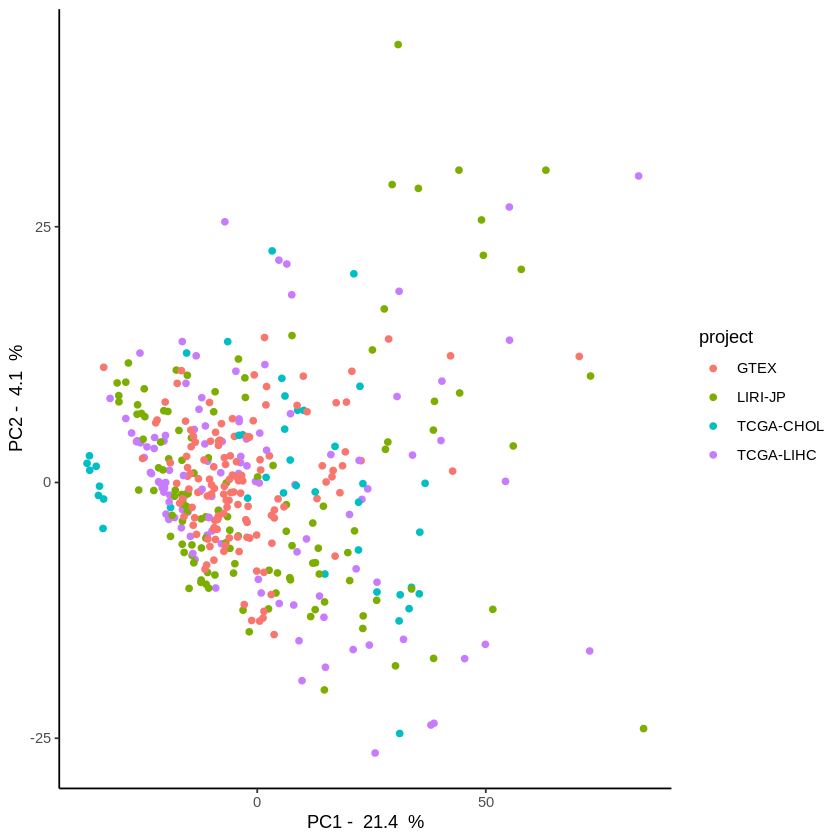

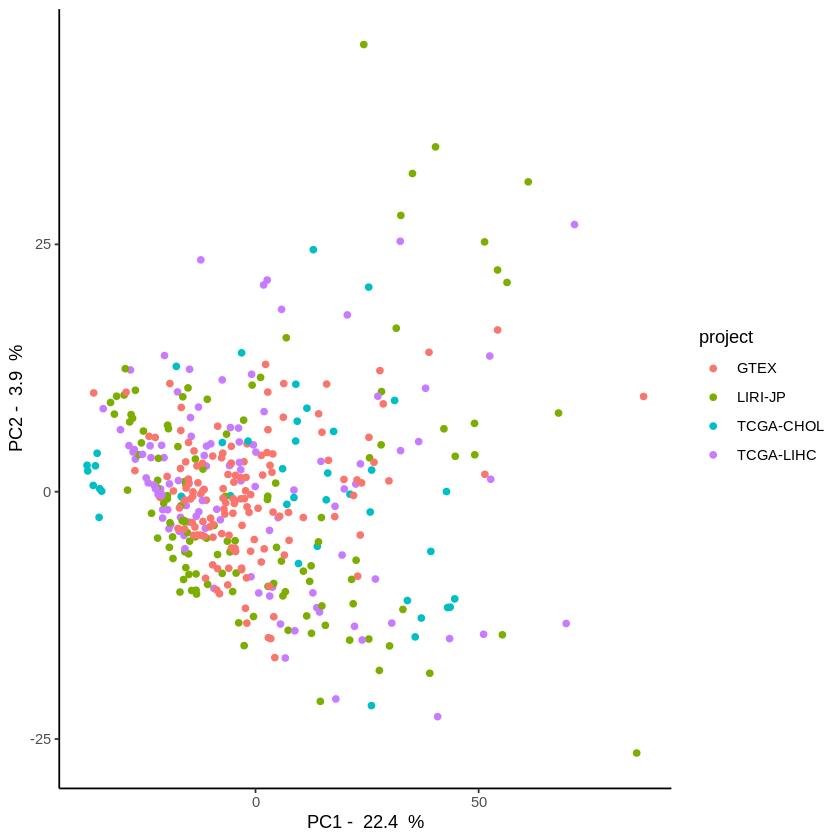

In [41]:
cp
csp

# Draw figure and export

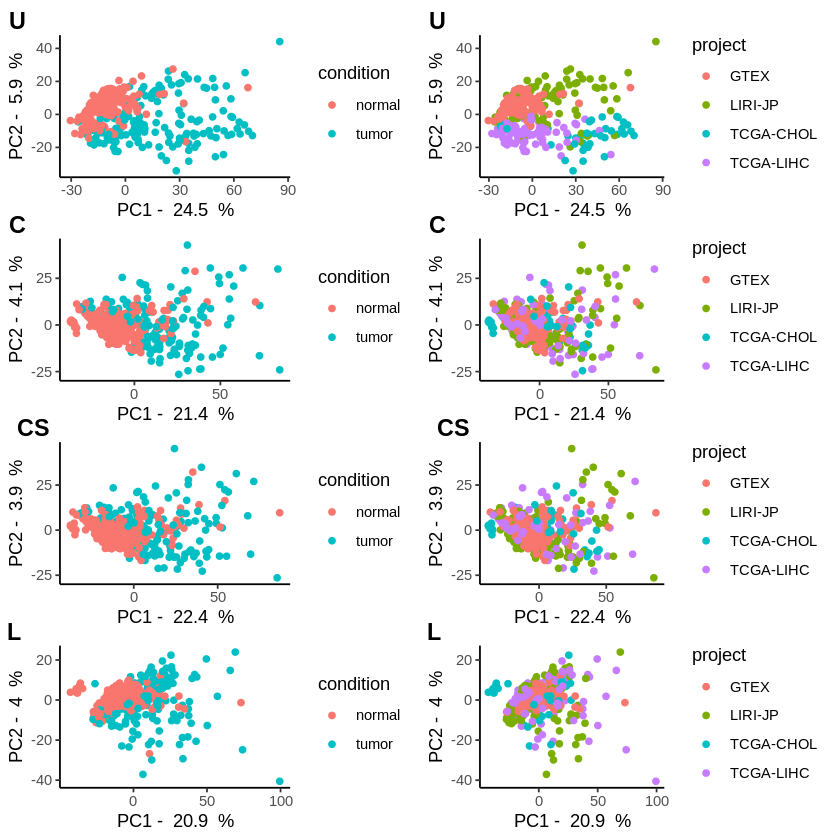

In [40]:
figure <- ggarrange(uc, up, cc, cp, csc, csp, lc, lp,
          labels = c("U", "U", 
                     "C", "C",
                     "CS", "CS",
                     "L", "L"),
                      vjust = 0.2,
                      nrow = 4, ncol = 2)


figure <- annotate_figure(figure, top = 
                           text_grob("", 
                                     color = "black", face = "bold", size = 12))
figure

In [42]:
ggexport(figure, filename = "liver_pca_batch_corrected_scaled_condition_project.pdf")
ggexport(figure, res=300, width=2500, height=2000, filename = "liver_pca_batch_corrected_scaled_condition_project.png")

file saved to liver_pca_batch_corrected_scaled_condition_project.pdf

file saved to liver_pca_batch_corrected_scaled_condition_project.png

